#HIGHER DIMENSIONAL QUANTILE REGRESSION

###Resources:
1) https://github.com/zillow/quantile-forest <br>
2) https://www.randomforestsrc.org/reference/quantreg.rfsrc.html

### Regression Overview

Regression is a statistical method used to investigate the relationship between a dependent variable (also known as the outcome or target variable) and one or more independent variables (predictors or features). The goal of regression analysis is to model the relationship between the variables and make predictions or estimate the effect of the predictors on the outcome variable.

In simple terms, regression helps us understand how changes in the independent variables are associated with changes in the dependent variable. It is widely used in various fields, including economics, finance, social sciences, and machine learning.


### Quantile Regression

Quantile regression models the relationship between predictors and different quantiles of the response variable. Unlike standard regression, it estimates not just the mean but also other quantiles like the median or upper/lower percentiles. This flexibility suits situations with asymmetric or variable distributions. Quantile regression is robust against outliers and provides a fuller picture of how predictors influence different parts of the response variable's distribution.

### Higher Dimension Quantile Regression

Higher dimension quantile regression is an extension of quantile regression for situations with multiple predictors. Unlike regular quantile regression, which predicts a single conditional quantile, this method estimates quantiles for high-dimensional data, considering all predictors together. By understanding how the response variable changes across different quantiles in complex datasets, this approach helps build robust models and draw insights, especially in scenarios with many predictors.

In [30]:
# Import all required library modules.
!pip install quantile_forest
!pip install altair_viewer

import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from datetime import time
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from quantile_forest import RandomForestQuantileRegressor
np.random.seed(42)
rng = check_random_state(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 6.8 MB/s eta 0:00:00


##Single-Output Quantile Regression with Random Forests on Synthetic Data

In this demonstration, we showcase Single-Output Quantile Regression using Random Forests on a dataset generated from a simple function. The goal is to train the model to approximate the function \( y = \sqrt{x} \)
​ and to determine prediction intervals (at quantiles 0.025 and 0.975) for each estimate (at the 0.5 quantile).

In [2]:
# Define the function to generate the target
def func(x):
    return x ** 0.5

n_samples = 2500
bounds = [0, 50]  # Adjusted domain

# Generate input data within the specified domain
X = np.linspace(*bounds, n_samples).reshape(-1, 1)
y = func(X).squeeze()  # Generate corresponding target values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and fit the RandomForestQuantileRegressor for single output quantile regression
qrf = RandomForestQuantileRegressor(max_samples_leaf=None, max_depth=4, random_state=0)
qrf.fit(X_train, y_train)

# Get predictions at 95% prediction intervals and median
quantiles = [0.025, 0.5, 0.975]
y_pred = qrf.predict(X, quantiles=quantiles)

# Create a DataFrame for plotting
df = pd.DataFrame({
    "x": X.squeeze(),
    "y_true": y,
    "y_pred": y_pred[:, 1],
    "y_pred_low": y_pred[:, 0],
    "y_pred_upp": y_pred[:, 2],
})

# Define legend for plotting
legend = {"0": "#f2a619", "1": "#006aff"}

def plot_single_output_quantile_regression(df, legend):
    tooltip = [
        alt.Tooltip("x:Q", format=",.3f", title="X"),
        alt.Tooltip("y_true:Q", format=",.3f", title="True Y"),
        alt.Tooltip("y_pred:Q", format=",.3f", title="Predicted Y"),
        alt.Tooltip("y_pred_low:Q", format=",.3f", title="Predicted Lower Y"),
        alt.Tooltip("y_pred_upp:Q", format=",.3f", title="Predicted Upper Y"),
    ]

    line = (
        alt.Chart(df)
        .mark_line(color="black", size=3)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred:Q", title="y"),
            tooltip=tooltip,
        )
    )

    area = (
        alt.Chart(df)
        .mark_area(opacity=0.25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred_low:Q", title="y"),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            tooltip=tooltip,
        )
    )

    chart = (
        (area + line)
        .configure_range(category=alt.RangeScheme(list(legend.values())))
        .properties(height=400, width=650, title="Single-Output Quantile Regression")
    )

    return chart

chart = plot_single_output_quantile_regression(df, legend)
chart


alt.LayerChart(...)

## Observations from Single-Output Quantile Regression with Random Forests on Synthetic Data

- **Prediction Accuracy**: The predicted curve closely follows the true function \( y = \sqrt{x} \), indicating a good fit of the model to the data.

- **Prediction Intervals**: The shaded area represents the prediction intervals at 95% confidence (0.025 and 0.975 quantiles), capturing the uncertainty in the predictions.

- **Model Performance**: There appears to be an oscillation about the function thus generating a wiggly line about the function.

## Single-Output Quantile Regression with Random Forests on Real-Life Dataset - 1

In this demonstration, Single-Output Quantile Regression with Random Forests is showcased on real-life housing data. The goal is to predict housing prices based on various house features. Using a subset of the housing dataset, the model estimates the median house value with prediction intervals. The approach employs a quantile random forest regressor with 100 decision trees for robust predictions.

In [3]:
# Load the cali Housing Prices dataset.
cali = pd.read_csv("housing.csv").dropna()
n_samples = min(len(cali), 2000)
perm = rng.permutation(n_samples)

cali = cali.iloc[perm]

X = cali.iloc[:, :8]
y = cali.iloc[:, 8]

print(X.head())
print()
print(y.head())

X = X.values
y = y.values



qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

      longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
407     -122.27     37.89                52.0       3046.0           373.0   
1197    -121.65     39.32                40.0        812.0           154.0   
1139    -121.57     39.74                17.0       1619.0           292.0   
736     -122.14     37.67                36.0       1487.0           249.0   
1765    -122.33     37.95                46.0       1543.0           339.0   

      population  households  median_income  
407        975.0       365.0         8.8342  
1197       374.0       142.0         2.7891  
1139       705.0       285.0         2.4623  
736        641.0       243.0         4.0682  
1765       777.0       322.0         4.0927  

407     430500.0
1197     73500.0
1139    126100.0
736     196200.0
1765    142600.0
Name: median_house_value, dtype: float64


5

### Cross-Validated Predictions with Quantile Random Forest

This code conducts k-fold cross-validation using Quantile Random Forest (QRF) to predict target variables with associated prediction intervals at quantiles [0.025, 0.5, 0.975]. It trains the model, generates predictions, and compiles results in a DataFrame.

In [4]:
# Using k-fold cross-validation, get predictions for all samples.
data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x * 1)  # convert to dollars

### Random Forest Regressor

The Random Forest Regressor is a machine learning algorithm used for regression tasks. It operates by constructing multiple decision trees during training and outputs the mean prediction of the individual trees for regression tasks. This ensemble approach provides robustness against overfitting and generally yields accurate predictions across various datasets. It is highly versatile and suitable for both small and large-scale regression problems.





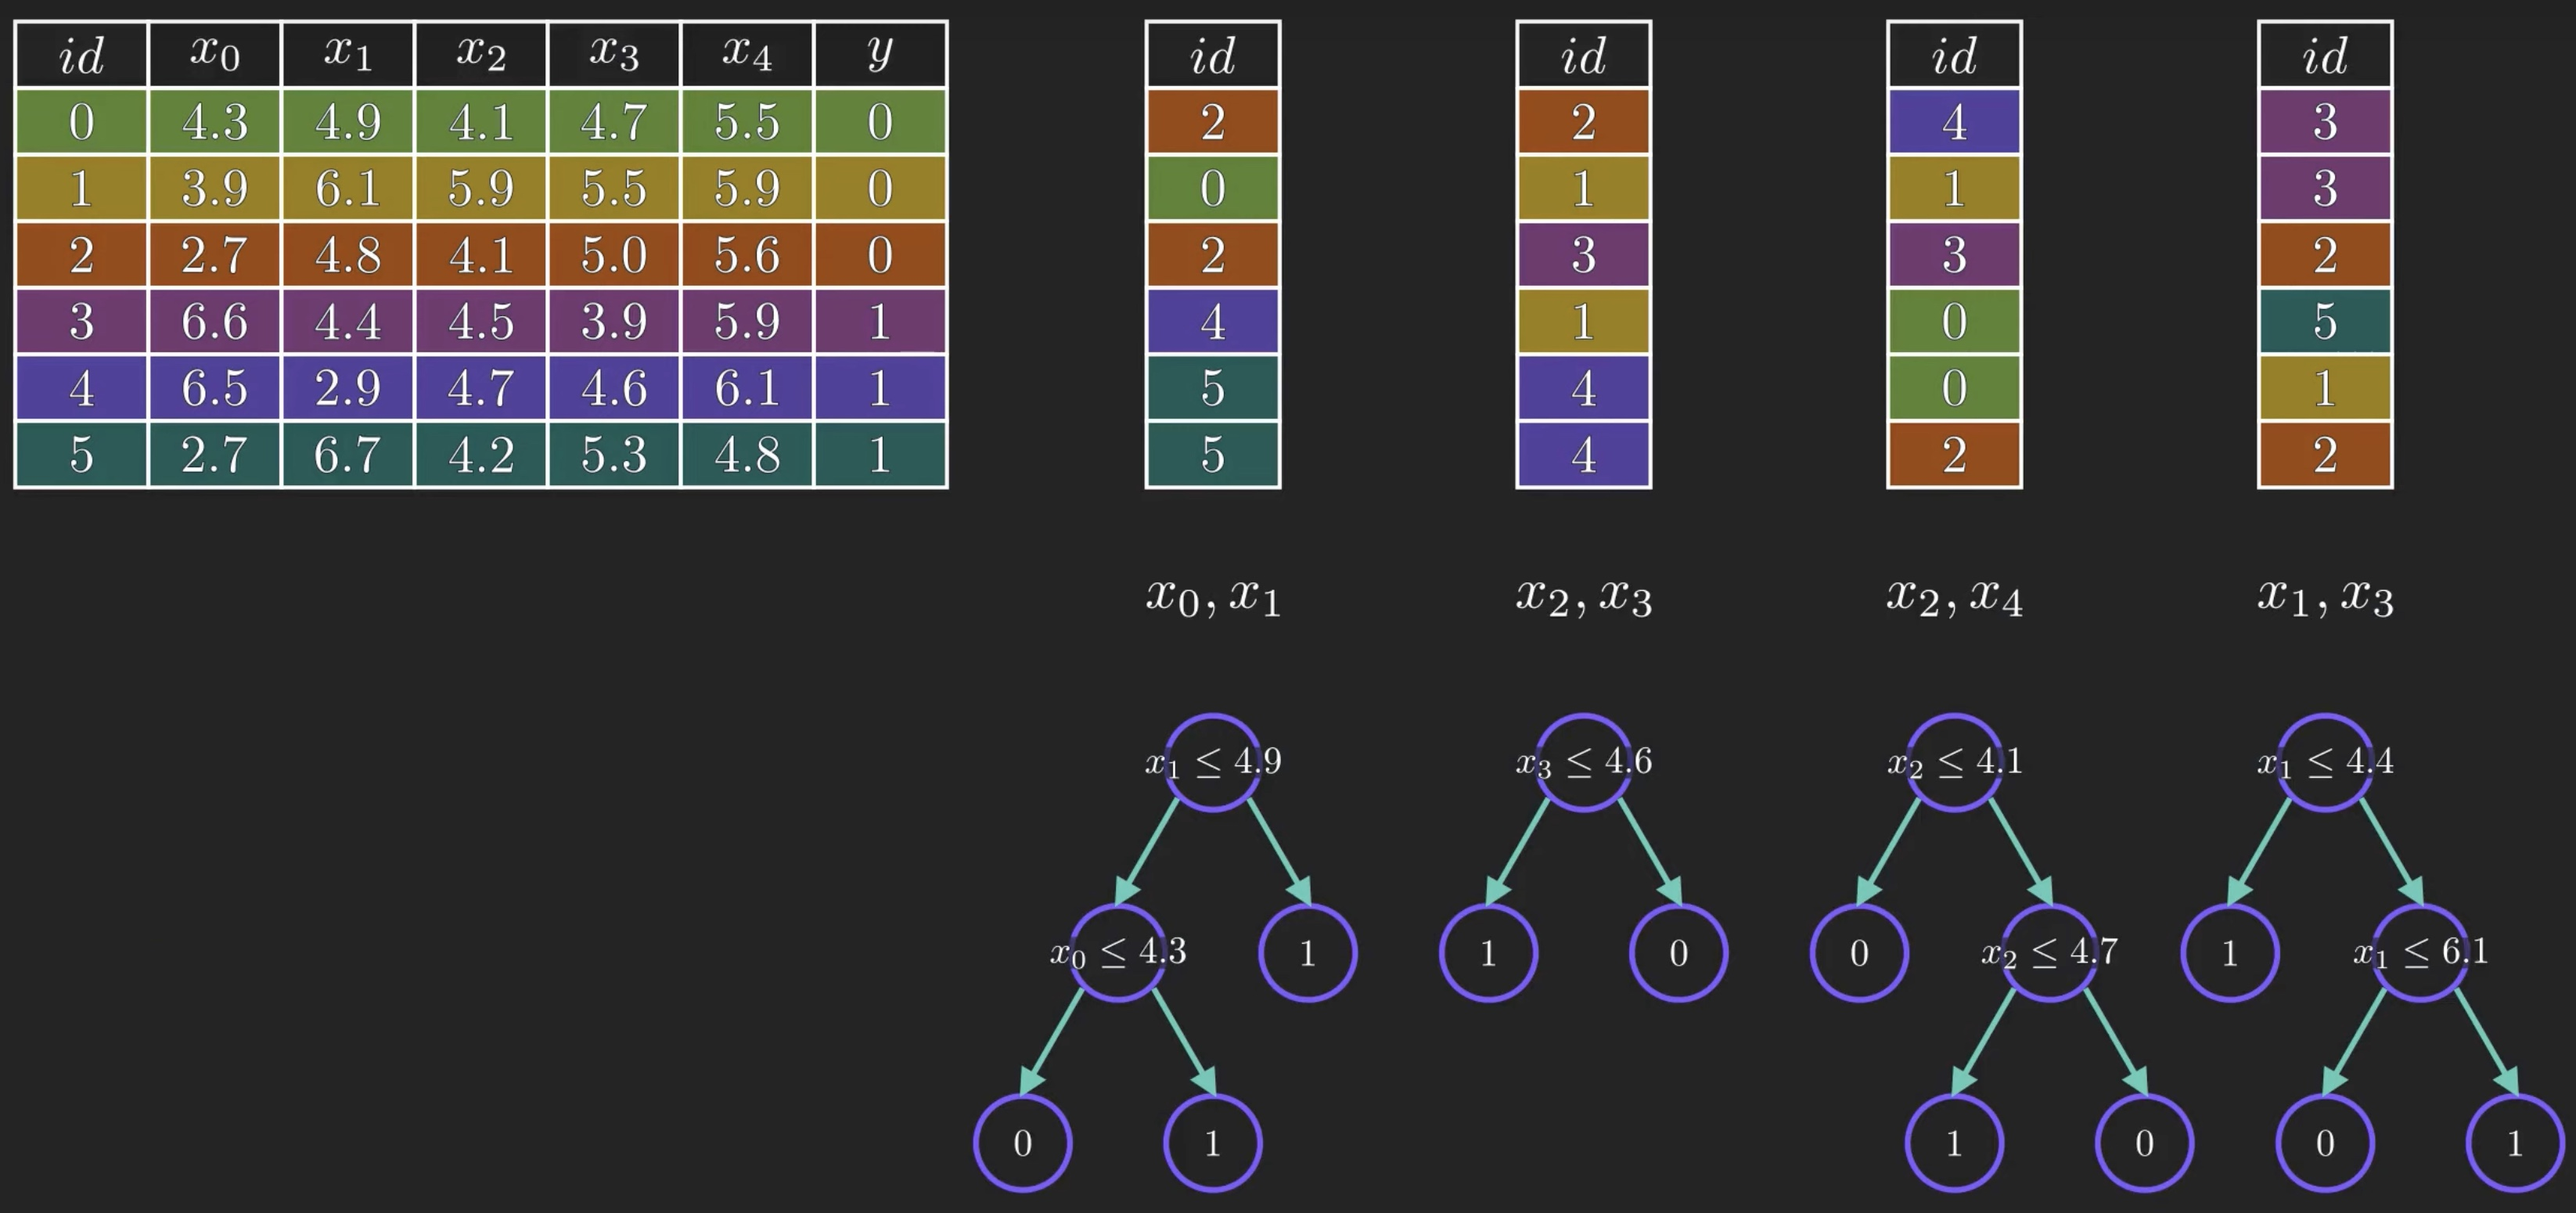

Utilizing the strength of the ensemble model, we extract predictions from each decision tree and derive quantiles from these collective predictions. This process allows us to establish prediction intervals for each estimate, aggregating information from the observations obtained from the individual trees.




In [5]:
def plot_calibration_and_intervals(df):
    def plot_calibration(df):
        domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
        ]

        base = alt.Chart(df)

        circle = base.mark_circle(size=30).encode(
            x=alt.X(
                "y_pred:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Fitted Values (conditional median)",
            ),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Observed Values",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("y_pred:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("y_pred:Q", title=""), color=alt.value("#006aff")
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        diagonal = (
            alt.Chart(
                pd.DataFrame({"var1": [domain[0], domain[1]], "var2": [domain[0], domain[1]]})
            )
            .mark_line(color="black", opacity=0.4, strokeDash=[2, 2])
            .encode(
                x=alt.X("var1:Q"),
                y=alt.Y("var2:Q"),
            )
        )

        chart = bar + tick_low + tick_upp + circle + diagonal
        return chart

    def plot_intervals(df):
        df = df.copy()

        # Order samples by interval width.
        y_pred_interval = df["y_pred_upp"] - df["y_pred_low"]
        sort_idx = np.argsort(y_pred_interval)
        df = df.iloc[sort_idx]
        df["idx"] = np.arange(len(df))

        # Center data, with the mean of the prediction interval at 0.
        mean = (df["y_pred_low"] + df["y_pred_upp"]) / 2
        df["y_true"] -= mean
        df["y_pred"] -= mean
        df["y_pred_low"] -= mean
        df["y_pred_upp"] -= mean

        x_domain = [0, len(df)]
        y_domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("idx:Q", format=",d", title="Sample Index"),
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price (Centered)"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price (Centered)"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
            alt.Tooltip("y_pred_width:Q", format="$,d", title="Prediction Interval Width"),
        ]

        base = alt.Chart(df).transform_calculate(
            y_pred_width=alt.datum["y_pred_upp"] - alt.datum["y_pred_low"]
        )

        circle = base.mark_circle(size=30).encode(
            x=alt.X("idx:Q", axis=alt.Axis(format=",d"), title="Ordered Samples"),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                title="Observed Values and Prediction Intervals (centered)",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("idx:Q", scale=alt.Scale(domain=x_domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=y_domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("idx:Q", title=""),
            color=alt.value("#006aff"),
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        chart = bar + tick_low + tick_upp + circle
        return chart

    chart1 = plot_calibration(df).properties(height=400, width=600)
    chart2 = plot_intervals(df).properties(height=400, width=600)
    return chart1, chart2


### Calibration and Prediction Intervals

The plots depict calibration of predicted vs. observed prices and prediction intervals centered around the observed values. In particular, Circular markers represent fitted values or the median housing price (0.5 quantile), ticks indicate upper (0.975 quantile) and lower (0.025 quantile) bounds and bars denote prediction intervals (95% prediction interval). The plots provide insights into model performance and uncertainty in predictions.

In [6]:
chart1, chart2 = plot_calibration_and_intervals(df)
print("Calibration plot\n")
chart1

Calibration plot



alt.LayerChart(...)

In [7]:
print("Prediction Intervals Plot")
chart2

Prediction Intervals Plot


alt.LayerChart(...)

1. **Calibration Plot:**
   - In the calibration plot, the predicted values closely align with the observed values, resembling the pattern of the y = x line.
   - The circular markers (fitted values) are generally aligned with the diagonal line, suggesting good calibration.
   - The spread of points around the diagonal indicates the variability in predictions.

2. **Prediction Intervals Plot:**
   - The bars represent the width of prediction intervals for each sample.
   - In the Prediction Intervals Plot, narrower bars indicate more favorable observations as they signify reduced uncertainty in predictions.
   - Widely spread bars indicate higher uncertainty, while narrower bars signify more precise predictions.
   - Consistent with calibration, the intervals capture the variability in the observed values.


## Similarly, we also performed single-output quantile regression analysis on the following datasets.
  - Bigmart Sales (https://www.kaggle.com/datasets/uniabhi/bigmart-sales-data)
  - Ames (https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset)

**USING AMES HOUSING DATASET**

In [8]:
data = pd.read_csv("ames.csv")

# data.dropna(inplace=True)
ordinal_cols = ordinal_cols = ["MS Zoning", "Street", "Alley", "Lot Shape", "Land Contour", "Utilities", "Lot Config", "Land Slope",
                "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl",
                "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Exter Qual", "Exter Cond", "Foundation", "Bsmt Qual",
                "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating", "Heating QC", "Central Air", "Electrical",
                "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Type", "Garage Finish", "Garage Qual",
                "Garage Cond", "Paved Drive", "Pool QC", "Fence", "Misc Feature", "Sale Type", "Sale Condition"]  # specify the categorical columns to encode
for col in ordinal_cols:
    data[col] = data[col].astype("category").cat.codes

data.dropna(inplace=True)
X = data.drop(["SalePrice"], axis=1).values
y = data["SalePrice"].values

qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# X[1]

data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x * 1)  # convert to dollars

chart1, chart2 = plot_calibration_and_intervals(df)
print("Calibration plot\n")
chart1

Calibration plot



alt.LayerChart(...)

In [9]:
print("Prediction Intervals Plot")
chart2

Prediction Intervals Plot


alt.LayerChart(...)

1. **Calibration Plot:**
   - In the calibration plot, the predicted values closely align with the observed values, resembling the pattern of the y = x line.
   - The circular markers (fitted values) are generally aligned with the diagonal line, suggesting good calibration.
   - The spread of points around the diagonal indicates the variability in predictions.

2. **Prediction Intervals Plot:**
   - The bars represent the width of prediction intervals for each sample.
   - In the Prediction Intervals Plot, narrower bars indicate more favorable observations as they signify reduced uncertainty in predictions.
   - Widely spread bars indicate higher uncertainty, while narrower bars signify more precise predictions.
   - Consistent with calibration, the intervals capture the variability in the observed values.


**USING BIGMART SALES DATSAET**

In [12]:
data = pd.read_csv('bigmart_sales.csv',nrows=2000)
data.dropna(inplace=True)
features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
target = 'Item_Outlet_Sales'

# Extract features and target
X = data[features].values
y = data[target].values


qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# Using k-fold cross-validation, get predictions for all samples.
data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x *1)  # convert to dollars

chart1, chart2 = plot_calibration_and_intervals(df)
print("Calibration plot\n")
chart1

Calibration plot



alt.LayerChart(...)

In [13]:
print("Prediction Intervals Plot")
chart2

Prediction Intervals Plot


alt.LayerChart(...)

1. **Calibration Plot:**
   - In the calibration plot, the predicted values align with the observed values when the conditional median is smaller but deviate more when the conditional median get larger and larger.
   - The circular markers (fitted values) are not aligned with the diagonal line, suggesting improper calibration.


2. **Prediction Intervals Plot:**
   - The bars represent the width of prediction intervals for each sample.
   - In the Prediction Intervals Plot, narrower bars indicate more favorable observations as they signify reduced uncertainty in predictions.
   - Widely spread bars indicate higher uncertainty, while narrower bars signify more precise predictions.
   - Consistent with calibration, the intervals capture the variability in the observed values.

##Multiple-Output Quantile Regression with QRFs

A dataset was generated comprising three columns: 'x', 'log(x + 1)', and 'log(x / 2)', where the latter two served as the target outputs. Uniformly distributed noise was added to the target outputs. Subsequently, a random forest quantile regressor was trained on this dataset to predict the targets at the 0.5 quantile, along with their corresponding prediction intervals at the 0.025 and 0.975 quantiles, representing 95% confidence intervals.

In [14]:
n_samples = 2500
bounds = [0, 100]

# Define functions that generate targets; each function maps to one target.
funcs = [
    {
        "signal": lambda x: np.log1p(x + 1),
        "noise": lambda x: np.log1p(x) * np.random.uniform(size=len(x)),
    },
    {
        "signal": lambda x: np.log1p(np.sqrt(x)),
        "noise": lambda x: np.log1p(x / 2) * np.random.uniform(size=len(x)),
    },
]

legend = {
    "0": "#f2a619",
    "1": "#006aff",
}


def make_func_Xy(funcs, bounds, n_samples):
    x = np.linspace(*bounds, n_samples)
    y = np.empty((len(x), len(funcs)))
    for i, func in enumerate(funcs):
        y[:, i] = func["signal"](x) + func["noise"](x)
    return np.atleast_2d(x).T, y


# Create the dataset with multiple target variables.
X, y = make_func_Xy(funcs, bounds, n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

qrf = RandomForestQuantileRegressor(max_samples_leaf=None, max_depth=4, random_state=0)
qrf.fit(X_train, y_train)  # fit on all of the targets simultaneously

# Get multiple-output predictions at 95% prediction intervals and median.
y_pred = qrf.predict(X, quantiles=[0.025, 0.5, 0.975])

df = pd.DataFrame(
    {
        "x": np.tile(X.squeeze(), len(funcs)),
        "y": y.reshape(-1, order="F"),
        "y_true": np.concatenate([f["signal"](X.squeeze()) for f in funcs]),
        "y_pred": np.concatenate([y_pred[:, i, 1] for i in range(len(funcs))]),
        "y_pred_low": np.concatenate([y_pred[:, i, 0] for i in range(len(funcs))]),
        "y_pred_upp": np.concatenate([y_pred[:, i, 2] for i in range(len(funcs))]),
        "target": np.concatenate([[f"{i}"] * len(X) for i in range(len(funcs))]),
    }
)


def plot_multioutputs(df, legend):
    click = alt.selection_multi(fields=["target"])

    color = alt.condition(
        click,
        alt.Color(
            "target:N",
            legend=alt.Legend(symbolOpacity=1),
            scale=alt.Scale(range=list(legend.values())),
            sort=list(legend.keys()),
            title="Target",
        ),
        alt.value("lightgray"),
    )

    tooltip = [
        alt.Tooltip("target:N", title="Target"),
        alt.Tooltip("x:Q", format=",.3f", title="X"),
        alt.Tooltip("y:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_true:Q", format=",.3f", title="Y"),
        alt.Tooltip("y_pred:Q", format=",.3f", title="Predicted Y"),
        alt.Tooltip("y_pred_low:Q", format=",.3f", title="Predicted Lower Y"),
        alt.Tooltip("y_pred_upp:Q", format=",.3f", title="Predicted Upper Y"),
    ]

    points = (
        alt.Chart(df)
        .mark_circle(color="black", opacity=0.25, size=25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False)),
            y=alt.Y("y:Q"),
            color=color,
            tooltip=tooltip,
        )
    )

    line = (
        alt.Chart(df)
        .mark_line(color="black", size=3)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred:Q", title="y"),
            color=color,
            tooltip=tooltip,
        )
    )

    area = (
        alt.Chart(df)
        .mark_area(opacity=0.25)
        .encode(
            x=alt.X("x:Q", scale=alt.Scale(nice=False), title="x"),
            y=alt.Y("y_pred_low:Q", title="y"),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=color,
            tooltip=tooltip,
        )
    )

    chart = (
        (points + area + line)
        .add_selection(click)
        .configure_range(category=alt.RangeScheme(list(legend.values())))
        .properties(height=400, width=650, title="Multi-target Prediction Intervals")
    )

    return chart


chart = plot_multioutputs(df, legend)
chart


alt.LayerChart(...)

### Observations from Multi-target Prediction Intervals

- **Prediction Behavior**:
  - The bold line represents the predicted values of the targets, 'Y', against the input variable 'X'. It generally follows the trend of the data points.
  - Prediction intervals (shaded areas) around the predicted values show the range within which the actual values are likely to fall. The region gets bigger for bigger values of x.
  
- **Target Differentiation**:
  - Each target ('log(x + 1)' and 'log(x ^ 0.5)') is differentiated by color, namely yellow representing ('log(x + 1)') and blue representing ('log(x ^ 0.5)').

- **Data Distribution**:
  - Data points ('Y') are represented by circles, with transparency to indicate overlapping points.
  - The spread and concentration of data points vary across different regions of 'X'.

In [34]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
from quantile_forest import RandomForestQuantileRegressor  # Assuming you have your own implementation of RandomForestQuantileRegressor

# Load the dataset
data = pd.read_csv("motor_temperatures.csv")

# Define the features and target variables
features = ["u_q", "coolant", "stator_winding", "u_d", "stator_tooth", "motor_speed", "i_d", "i_q", "ambient", "torque"]
targets = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

# Split the data into features and targets
X = data[features]
y = data[targets]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and fit the RandomForestQuantileRegressor for multiple-output quantile regression
qrf = RandomForestQuantileRegressor(max_samples_leaf=None, max_depth=4, random_state=0)
qrf.fit(X_train, y_train)

# Get multiple-output predictions at 95% prediction intervals and median
y_pred = qrf.predict(X, quantiles=[0.025, 0.5, 0.975])

print(y_pred.shape)

# Create a DataFrame for plotting
df = pd.DataFrame({
    "x": np.arange(len(X)),  # Assuming each row represents a data point
    "y_true_pm": y["pm"],
    "y_true_stator_yoke": y["stator_yoke"],
    "y_true_stator_tooth": y["stator_tooth"],
    "y_true_stator_winding": y["stator_winding"],
    "y_pred_pm": y_pred[:, 0, 1],  # Predicted values at the 0.5 quantile for pm
    "y_pred_stator_yoke": y_pred[:, 1, 1],  # Predicted values at the 0.5 quantile for stator_yoke
    "y_pred_stator_tooth": y_pred[:, 2, 1],  # Predicted values at the 0.5 quantile for stator_tooth
    "y_pred_stator_winding": y_pred[:, 3, 1],  # Predicted values at the 0.5 quantile for stator_winding
    "y_pred_pm_low": y_pred[:, 0, 0],  # Predicted values at the 0.025 quantile for pm
    "y_pred_stator_yoke_low": y_pred[:, 1, 0],  # Predicted values at the 0.025 quantile for stator_yoke
    "y_pred_stator_tooth_low": y_pred[:, 2, 0],  # Predicted values at the 0.025 quantile for stator_tooth
    "y_pred_stator_winding_low": y_pred[:, 3, 0],  # Predicted values at the 0.025 quantile for stator_winding
    "y_pred_pm_high": y_pred[:, 0, 2],  # Predicted values at the 0.975 quantile for pm
    "y_pred_stator_yoke_high": y_pred[:, 1, 2],  # Predicted values at the 0.975 quantile for stator_yoke
    "y_pred_stator_tooth_high": y_pred[:, 2, 2],  # Predicted values at the 0.975 quantile for stator_tooth
    "y_pred_stator_winding_high": y_pred[:, 3, 2],  # Predicted values at the 0.975 quantile for stator_winding
})

# Define legend for plotting
legend = {"pm": "#f2a619", "stator_yoke": "#006aff", "stator_tooth": "#00ff00", "stator_winding": "#ff0000"}

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


(2000, 4, 3)


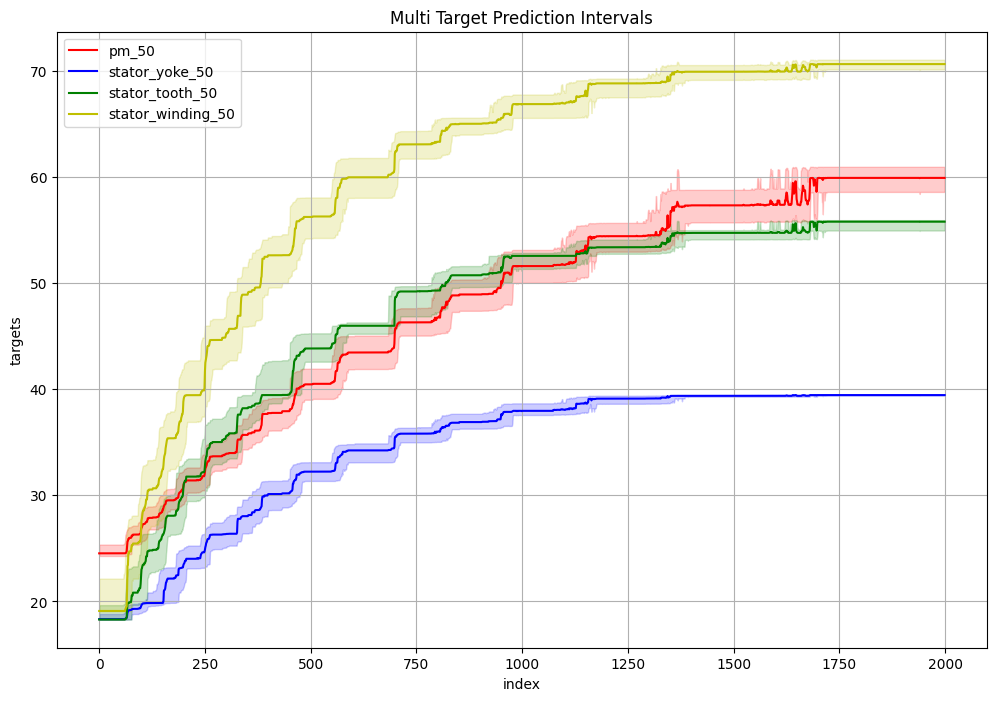

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot pm
sns.lineplot(data=df, x='x', y='y_pred_pm', label="pm_50", color='r')
sns.lineplot(data=df, x='x', y='y_pred_stator_yoke', label="stator_yoke_50", color='b')
sns.lineplot(data=df, x='x', y='y_pred_stator_tooth', label="stator_tooth_50", color='g')
sns.lineplot(data=df, x='x', y='y_pred_stator_winding', label="stator_winding_50", color='y')

# Fill between pm and stator_yoke
plt.fill_between(df['x'], df['y_pred_pm_low'], df['y_pred_pm_high'], color='r', alpha=0.2)
plt.fill_between(df['x'], df['y_pred_stator_yoke_low'], df['y_pred_stator_yoke_high'], color='b', alpha=0.2)
plt.fill_between(df['x'], df['y_pred_stator_tooth_low'], df['y_pred_stator_tooth_high'], color='g', alpha=0.2)
plt.fill_between(df['x'], df['y_pred_stator_winding_low'], df['y_pred_stator_winding_high'], color='y', alpha=0.2)

plt.grid()
plt.title("Multi Target Prediction Intervals")
plt.xlabel("index")
plt.ylabel("targets")
plt.legend()
plt.show()


### Observations from Multi-target Prediction Intervals

- **Prediction Behavior**:
  - The bold line represents the predicted values of the targets, 'Y', against the input variable 'X'. It generally follows the trend of the data points.
  - Prediction intervals (shaded areas) around the predicted values show the range within which the actual values are likely to fall. The region gets smaller for bigger values of x.